In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

In [6]:
??datasets

## MNIST

In [33]:
train = datasets.MNIST("", train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST("", train=False, download=True, 
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))

In [13]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [36]:
??nn.Linear

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [45]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [46]:
x = torch.randn((28, 28))
x = x.view((-1, 28*28))

In [53]:
net(x)

tensor([[-2.3127, -2.2458, -2.4122, -2.3093, -2.1731, -2.3708, -2.2456, -2.2142,
         -2.4568, -2.3212]], grad_fn=<LogSoftmaxBackward>)

In [54]:
import torch.optim as optim

In [58]:
optimizer = optim.Adam(net.parameters(), lr=3e-3)

In [60]:
EPOCHS = 3

for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data
        net.zero_grad() # we do this explicitly because it gives us the freedom to accumulate gradients over two batches,
        # essentially giving us the benefits (not speed) of training with a batchsize of batchsize * 2
        output = net(X.view(-1, 28*28)) # net is a callable due to a __call__
        loss = F.nll_loss(output, y)
        loss.backward() # calculate gradients
        optimizer.step() # update weights
    print(loss)

tensor(0.8358, grad_fn=<NllLossBackward>)
tensor(0.0708, grad_fn=<NllLossBackward>)
tensor(0.0274, grad_fn=<NllLossBackward>)


In [62]:
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for data in testset:
        X, y = data
        output = net(X.view(-1, 784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
    print(f"Accuracy: {correct / total}")

Accuracy: 0.9643


## ConvNets: DogsVSCats

In [86]:
import cv2
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np

Neat little create to create one-hot vectors!

In [70]:
np.eye(5)[1]

array([0., 1., 0., 0., 0.])

In [73]:
REBUILD_DATA = True

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "D:/Datasets/PetImages/Cat/"
    DOGS = "D:/Datasets/PetImages/Dog/"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)

In [74]:
if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

D:/Datasets/PetImages/Cat/


C:\Users\mygl5\Anaconda3\envs\fastai-torch1.1\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



D:/Datasets/PetImages/Dog/



Cats:  12476
Dogs:  12470


In [76]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [78]:
%matplotlib inline

In [80]:
import matplotlib.pyplot as plt

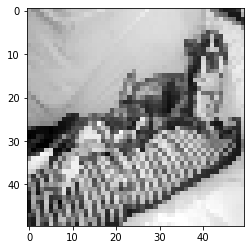

In [81]:
plt.imshow(training_data[1][0], cmap="gray")

In [82]:
training_data[1][1]

array([0., 1.])

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [104]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self.to_linear = None
        self.convs(x) # TODO: is this really the best way to do this?

        self.fc1 = nn.Linear(self.to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
            
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self.to_linear is None:
            self.to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.to_linear) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [105]:
net = Net()

In [101]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=3e-3)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(VAL_PCT * len(X))
val_size

2494

In [118]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [106]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        optimizer.zero_grad() # same as net.zero_grad() if your network as a whole has only 1 optimizer
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)
        

C:\Users\mygl5\Anaconda3\envs\fastai-torch1.1\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



tensor(0.2492, grad_fn=<MseLossBackward>)


### Moving to the GPU

In [107]:
torch.cuda.is_available()

True

In [108]:
device = torch.device("cuda:0"); device

In [110]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [111]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [123]:
EPOCHS = 10

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=3e-3)
    loss_function = nn.MSELoss()
    
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad() # same as net.zero_grad() if your network as a whole has only 1 optimizer
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch}, Loss: {loss}")

In [124]:
train(net)

C:\Users\mygl5\Anaconda3\envs\fastai-torch1.1\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Epoch: 0, Loss: 0.16798289120197296



Epoch: 1, Loss: 0.13324610888957977



Epoch: 2, Loss: 0.11955352872610092



Epoch: 3, Loss: 0.10725510120391846



Epoch: 4, Loss: 0.10987170785665512



Epoch: 5, Loss: 0.08683355897665024



Epoch: 6, Loss: 0.06201210245490074



Epoch: 7, Loss: 0.059197284281253815



Epoch: 8, Loss: 0.055555425584316254



Epoch: 9, Loss: 0.0691920816898346


In [125]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i].to(device))
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print(f"Accuracy: {correct/total}")

In [126]:
test(net)

C:\Users\mygl5\Anaconda3\envs\fastai-torch1.1\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Accuracy: 0.7068965517241379


### Putting it all together

In [ ]:
import cv2
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [127]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "D:/Datasets/PetImages/Cat/"
    DOGS = "D:/Datasets/PetImages/Dog/"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
        
if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()
    
training_data = np.load("training_data.npy", allow_pickle=True)


if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self.to_linear = None
        self.convs(x) # TODO: is this really the best way to do this?

        self.fc1 = nn.Linear(self.to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
            
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self.to_linear is None:
            self.to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.to_linear) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(VAL_PCT * len(X))

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]


EPOCHS = 10

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=3e-3)
    loss_function = nn.MSELoss()
    
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad() # same as net.zero_grad() if your network as a whole has only 1 optimizer
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch}, Loss: {loss}")
        
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i].to(device))
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print(f"Accuracy: {correct/total}")
    
net = Net().to(device)
train(net)
test(net)

C:\Users\mygl5\Anaconda3\envs\fastai-torch1.1\lib\site-packages\ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 0, Loss: 0.24455560743808746



Epoch: 1, Loss: 0.23729225993156433



Epoch: 2, Loss: 0.2372773289680481



Epoch: 3, Loss: 0.207295760512352



Epoch: 4, Loss: 0.1998835951089859



Epoch: 5, Loss: 0.1727912425994873



Epoch: 6, Loss: 0.1645793318748474



Epoch: 7, Loss: 0.17727920413017273



Epoch: 8, Loss: 0.14147986471652985



Epoch: 9, Loss: 0.1407385915517807


C:\Users\mygl5\Anaconda3\envs\fastai-torch1.1\lib\site-packages\ipykernel_launcher.py:117: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Accuracy: 0.6792301523656776
